In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/current/gui/bi.pickle
147


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t_pen = 0.96

In [5]:
file_ = '1_m.pickle'
folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

/1


In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [0]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [7]:
bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

In [9]:
# get initial parameters and target states

i_range = [20,50]

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  20 0.4500000000000001 0.4750000000000002
-------  50 0.47500000000000014 0.6000000000000003


In [10]:
# get uncontrolled cost
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(wp, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  636.9058225135838
RUN  0 , total integrated cost =  636.9058225135838
Gradient descend method:  None
RUN  0 , total integrated cost =  636.9058225135838
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  797.1477718037709
RUN  0 , total integrated cost =  797.1477718037709
Gradient descend method:  None
RUN  0 , total integrated cost =  797.1477718037709
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  48.6693338482971
RUN  2 , total integrated cost =  44.37245884829697
RUN  3 , total integrated cost =  44.250388535797015
RUN  4 , total integrated cost =  44.25007859164417
RUN  5 , total integrated cost =  44.25006667071607
RUN  6 , total integrated cost =  44.2500661327297
RUN  7 , total integrated cost =  44.25006612203635
RUN  8 , total integrated cost =  44.250066099946906
RUN  9 , total integrated cost =  44.25006608893835
RUN  10 , total integrated cost =  44.2500660641686
RUN  10 , total integrated cost =  44.2500660641686
Improved over  10  iterations in  2.35799940204015  seconds by  71.43670517748298  percent.


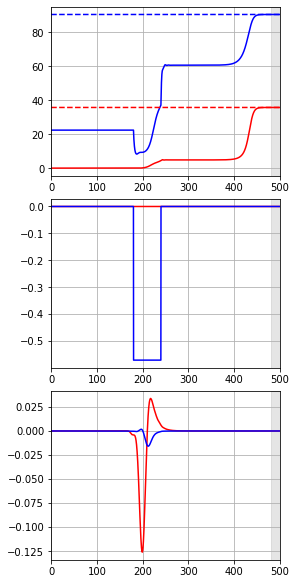

uncontrolled cost :  636.9058225135838
cost splitting :  3.691061797581887e-07 [0.        4.4250066]
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  61.16933384829721
RUN  2 , total integrated cost =  55.309958848297555
RUN  3 , total integrated cost =  55.22450962954758
RUN  4 , total integrated cost =  55.218787583649075
RUN  5 , total integrated cost =  55.21860876971455
RUN  6 , total integrated cost =  55.218607567819454
RUN  7 , total integrated cost =  55.21860756407337
RUN  8 , total integrated cost =  51.136075058544286
RUN  9 , total integrated cost =  50.30599477299686
RUN  10 , total integrated cost =  50.28615833529056
RUN  10 , total integrated cost =  50.28615833529056
Improved over  10  iterations in  2.8114786469959654  seconds by  67.54042437044521

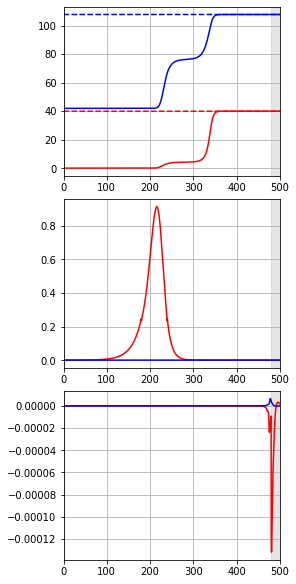

uncontrolled cost :  797.1477718037709
cost splitting :  9.708224442740693e-06 [5.02861578 0.        ]


In [52]:
cgv = None
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    cost.setParams(wp, 0., 10.)
    max_it = int(10)

    if i == 20:
        control0[0,1,1800:2400] = -2.
        c_var = [1]
    if i == 50:
        control0[0,0,1800:2400] = 2.
        c_var = [0]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
        ax[1].plot(plot_time_array, bestControl_[i][0,0,n_pre-1:-n_post+1], color = 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[1].plot(plot_time_array, bestControl_[i][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')


        ax[2].plot(plot_time_array, phi_[0,0,:], color = 'red')
        ax[2].plot(plot_time_array, phi_[0,1,:], color = 'blue')
        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])    

-------  20 0.4500000000000001 0.4750000000000002
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 40.7196485299508
interpolate adjoint :  True True True
initial cost =  204.6666772777748
RUN  0 , total integrated cost =  204.6666772777748
Gradient descend method:  None
RUN  1 , total integrated cost =  204.66667727776138
RUN  2 , total integrated cost =  204.66667727776084
RUN  3 , total integrated cost =  204.6666772777601
RUN  4 , total integrated cost =  204.6666772777595
RUN  5 , total integrated cost =  204.66667727775888
RUN  6 , total integrated cost =  204.66667727772779
RUN  7 , total integrated cost =  204.6666772776971
RUN  8 , total integrated cost =  204.66667727769587
RUN  9 , total integrated cost =  204.66667727769465
RUN  10 , total integrated cost =  204.6666772776939
RUN  11 , total integrated cost =  204.66667727769283
RUN  12 , total integrated cost =  204.66667727769214
RUN  13 , total integrated cost =  204.66667727769146
RUN  14 , t

RUN  6 , total integrated cost =  312.83179450588216
RUN  7 , total integrated cost =  312.83179450088846
RUN  8 , total integrated cost =  312.83179450086703
RUN  9 , total integrated cost =  312.8317945008521
RUN  10 , total integrated cost =  312.8317945008363
RUN  11 , total integrated cost =  312.8317945008255
RUN  12 , total integrated cost =  312.8317945008123
RUN  13 , total integrated cost =  312.8317945007977
RUN  14 , total integrated cost =  312.83179450078035
RUN  15 , total integrated cost =  312.8317945007646
RUN  16 , total integrated cost =  312.8317945007432
RUN  17 , total integrated cost =  312.8317945006845
RUN  18 , total integrated cost =  312.8317945006242
RUN  19 , total integrated cost =  312.8317945005868
RUN  20 , total integrated cost =  312.8317945005477
RUN  30 , total integrated cost =  312.8317945004421
RUN  40 , total integrated cost =  312.8317944995577
RUN  50 , total integrated cost =  312.83179449945163
RUN  60 , total integrated cost =  312.764817

RUN  1 , total integrated cost =  358.1186532369159
RUN  2 , total integrated cost =  358.11865323691524
RUN  3 , total integrated cost =  358.1186532369152
RUN  4 , total integrated cost =  358.1186532369152
Control only changes marginally.
RUN  4 , total integrated cost =  358.1186532369152
Improved over  4  iterations in  3.0844794400036335  seconds by  1.4908607681718422e-10  percent.
cost splitting :  1.102104197951362e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 86.71359876436243
interpolate adjoint :  True True True
initial cost =  434.11951567617325
RUN  0 , total integrated cost =  434.11951567617325
Gradient descend method:  None
RUN  1 , total integrated cost =  434.11951567607923
RUN  2 , total integrated cost =  434.1195156760783
RUN  3 , total integrated cost =  434.1195156760776
RUN  4 , total integrated cost =  434.1195156760775
RUN  5 , total integrated cost =  434.1195156760767
RUN  6 , total integrated cost =  434.1195156760764
RUN  7 , total integr

RUN  1 , total integrated cost =  107.37149035589245
RUN  2 , total integrated cost =  107.37149035589006
RUN  3 , total integrated cost =  107.37149035589
RUN  4 , total integrated cost =  107.37149035588993
RUN  5 , total integrated cost =  107.37149035588989
RUN  6 , total integrated cost =  107.37149035588986
RUN  7 , total integrated cost =  107.37149035588986
Control only changes marginally.
RUN  7 , total integrated cost =  107.37149035588986
Improved over  7  iterations in  4.152808267972432  seconds by  3.3906815133377677e-09  percent.
cost splitting :  1.0966338583638046e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 21.040656424697016
interpolate adjoint :  True True True
initial cost =  105.33710678396827
RUN  0 , total integrated cost =  105.33710678396827
Gradient descend method:  None
RUN  1 , total integrated cost =  105.33710678396811
RUN  2 , total integrated cost =  105.33710678396808
RUN  3 , total integrated cost =  105.33710678396808
Control only c

RUN  1 , total integrated cost =  0.8644649871415757
RUN  2 , total integrated cost =  0.8644649871413057
RUN  3 , total integrated cost =  0.8644649871413043
RUN  4 , total integrated cost =  0.8644649871412888
RUN  5 , total integrated cost =  0.8644649871412721
RUN  6 , total integrated cost =  0.864464987141271
RUN  7 , total integrated cost =  0.8644649871412697
RUN  8 , total integrated cost =  0.8644649871412697
Control only changes marginally.
RUN  8 , total integrated cost =  0.8644649871412697
Improved over  8  iterations in  4.925375130958855  seconds by  8.073784840689768e-08  percent.
cost splitting :  1.0955031972534679e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 38.33348643620031
interpolate adjoint :  True True True
initial cost =  191.91124379306098
RUN  0 , total integrated cost =  191.91124379306098
Gradient descend method:  None
RUN  1 , total integrated cost =  191.91124379108913
RUN  2 , total integrated cost =  191.9112437910887
RUN  3 , total 

RUN  3 , total integrated cost =  311.76288571088446
RUN  4 , total integrated cost =  311.76288571088446
Control only changes marginally.
RUN  4 , total integrated cost =  311.76288571088446
Improved over  4  iterations in  2.466149845975451  seconds by  6.186269274621736e-10  percent.
cost splitting :  1.1009618936280026e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 26.62932801707735
interpolate adjoint :  True True True
initial cost =  133.3160101686382
RUN  0 , total integrated cost =  133.3160101686382
Gradient descend method:  None
RUN  1 , total integrated cost =  133.31601016790887
RUN  2 , total integrated cost =  133.31601016790876
RUN  3 , total integrated cost =  133.31601016790876
Control only changes marginally.
RUN  3 , total integrated cost =  133.31601016790876
Improved over  3  iterations in  2.0060997089603916  seconds by  5.471463282447075e-10  percent.
cost splitting :  1.0970920640436338e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0

RUN  1 , total integrated cost =  454.26413601175506
RUN  2 , total integrated cost =  454.2641360117541
RUN  3 , total integrated cost =  454.2641360117541
Control only changes marginally.
RUN  3 , total integrated cost =  454.2641360117541
Improved over  3  iterations in  2.201825208030641  seconds by  7.894129794294713e-11  percent.
cost splitting :  1.1045092016341404e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 77.93833526737936
interpolate adjoint :  True True True
initial cost =  390.18738520632786
RUN  0 , total integrated cost =  390.18738520632786
Gradient descend method:  None
RUN  1 , total integrated cost =  390.18738520626914
RUN  2 , total integrated cost =  390.18738520626874
RUN  3 , total integrated cost =  390.18738520626874
Control only changes marginally.
RUN  3 , total integrated cost =  390.18738520626874
Improved over  3  iterations in  2.114104897947982  seconds by  1.5148771126405336e-11  percent.
cost splitting :  1.1028892572286781e-05 [5.0

RUN  4 , total integrated cost =  603.5947825495138
RUN  5 , total integrated cost =  603.5947825495138
Control only changes marginally.
RUN  5 , total integrated cost =  603.5947825495138
Improved over  5  iterations in  3.954420265974477  seconds by  1.2818190953112207e-11  percent.
cost splitting :  1.1085390849786024e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 101.56890190802164
interpolate adjoint :  True True True
initial cost =  508.4905150304021
RUN  0 , total integrated cost =  508.4905150304021
Gradient descend method:  None
RUN  1 , total integrated cost =  508.4905150302922
RUN  2 , total integrated cost =  508.4905150302916
RUN  3 , total integrated cost =  508.4905150302914
RUN  4 , total integrated cost =  508.4905150302908
RUN  5 , total integrated cost =  508.4905150302908
Control only changes marginally.
RUN  5 , total integrated cost =  508.4905150302908
Improved over  5  iterations in  4.064928526990116  seconds by  2.1898927116126288e-11  percent

RUN  1 , total integrated cost =  90.04696802548658
RUN  2 , total integrated cost =  90.04696802548072
RUN  3 , total integrated cost =  90.04696802548067
RUN  4 , total integrated cost =  90.04696802548067
Control only changes marginally.
RUN  4 , total integrated cost =  90.04696802548067
Improved over  4  iterations in  3.3608745359815657  seconds by  7.113314381967939e-09  percent.
cost splitting :  1.0963511609500033e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 89.08610156319735
interpolate adjoint :  True True True
initial cost =  445.9971194154262
RUN  0 , total integrated cost =  445.9971194154262
Gradient descend method:  None
RUN  1 , total integrated cost =  445.9971194119046
RUN  2 , total integrated cost =  445.9971194118951
RUN  3 , total integrated cost =  445.99711941189486
RUN  4 , total integrated cost =  445.99711941189486
Control only changes marginally.
RUN  4 , total integrated cost =  445.99711941189486
Improved over  4  iterations in  3.501501

RUN  1 , total integrated cost =  459.33453847428467
RUN  2 , total integrated cost =  459.3345384742819
RUN  3 , total integrated cost =  459.3345384742819
Control only changes marginally.
RUN  3 , total integrated cost =  459.3345384742819
Improved over  3  iterations in  3.1401614230126143  seconds by  3.78904019271431e-10  percent.
cost splitting :  1.10471388342283e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 39.882983469081964
interpolate adjoint :  True True True
initial cost =  199.66858416541146
RUN  0 , total integrated cost =  199.66858416541146
Gradient descend method:  None
RUN  1 , total integrated cost =  199.668584164249
RUN  2 , total integrated cost =  199.66858416424756
RUN  3 , total integrated cost =  199.66858416424756
Control only changes marginally.
RUN  3 , total integrated cost =  199.66858416424756
Improved over  3  iterations in  3.2357236290117726  seconds by  5.82915049562871e-10  percent.
cost splitting :  1.0984157309272827e-05 [5.00636

RUN  1 , total integrated cost =  224.38279350879353
RUN  2 , total integrated cost =  224.38279350879156
RUN  3 , total integrated cost =  224.38279350879137
RUN  4 , total integrated cost =  224.38279350878867
RUN  5 , total integrated cost =  224.38279350878543
RUN  6 , total integrated cost =  224.38279350878543
Control only changes marginally.
RUN  6 , total integrated cost =  224.38279350878543
Improved over  6  iterations in  5.860135375987738  seconds by  5.547917680814862e-10  percent.
cost splitting :  1.0989603581656963e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 140.2396881456704
interpolate adjoint :  True True True
initial cost =  702.0904025960303
RUN  0 , total integrated cost =  702.0904025960303
Gradient descend method:  None
RUN  1 , total integrated cost =  702.0904025921144
RUN  2 , total integrated cost =  702.0904025921116
RUN  3 , total integrated cost =  702.0904025921116
Control only changes marginally.
RUN  3 , total integrated cost =  702.

RUN  1 , total integrated cost =  14.252183835196552
RUN  2 , total integrated cost =  14.25218383519508
RUN  3 , total integrated cost =  14.252183835195055
RUN  4 , total integrated cost =  14.252183835195034
RUN  5 , total integrated cost =  14.252183835195034
Control only changes marginally.
RUN  5 , total integrated cost =  14.252183835195034
Improved over  5  iterations in  3.565386458998546  seconds by  3.9070030766197306e-08  percent.
cost splitting :  1.0955346726116078e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 134.2766014412799
interpolate adjoint :  True True True
initial cost =  672.2370422831963
RUN  0 , total integrated cost =  672.2370422831963
Gradient descend method:  None
RUN  1 , total integrated cost =  672.2370422699944
RUN  2 , total integrated cost =  672.2370422699772
RUN  3 , total integrated cost =  672.2370422699768
RUN  4 , total integrated cost =  672.2370422699724
RUN  5 , total integrated cost =  672.2370422699682
RUN  6 , total integ

RUN  3 , total integrated cost =  239.9668736474371
RUN  4 , total integrated cost =  239.96687364736013
RUN  5 , total integrated cost =  239.96687364735976
RUN  6 , total integrated cost =  239.9668736473597
RUN  7 , total integrated cost =  239.96687364735962
RUN  8 , total integrated cost =  239.96687364735953
RUN  9 , total integrated cost =  239.96687364735953
Control only changes marginally.
RUN  9 , total integrated cost =  239.96687364735953
Improved over  9  iterations in  7.806817878037691  seconds by  2.4091661998681957e-10  percent.
cost splitting :  1.0992746422324825e-05 [5.00636026e+00 1.37050678e-17]
set cost params:  0.05 0.0 137.29130806903558
interpolate adjoint :  True True True
initial cost =  687.3297497379704
RUN  0 , total integrated cost =  687.3297497379704
Gradient descend method:  None
RUN  1 , total integrated cost =  687.3297497345709
RUN  2 , total integrated cost =  687.3297497345685
RUN  3 , total integrated cost =  687.3297497345678
RUN  4 , total int

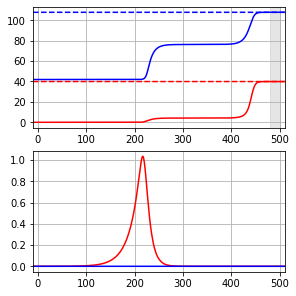

In [92]:
c_var = [0,1]
conv = [None] * len(exc)
max_it = int(100)

tol = 1e-15

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i == 20:
        continue
    
    while not conv[i]:

        weight_ = random.random() * ( cost_uncontrolled[i] -
                                     costnode_[i][0][0][0] ) / sum( costnode_[i][2][0][:] )
            
        aln.params.duration = dur
        cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            conv[i] = True

        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])

        if conv[i]:
            time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]
        
            fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
            ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
            ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
            ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
            ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
            ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
            ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
            ax[0].set_xlim(-dur_pre,dur+dur_post)
            ax[1].set_xlim(-dur_pre,dur+dur_post)
            ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        
        k += 1

-------  20 0.4500000000000001 0.4750000000000002


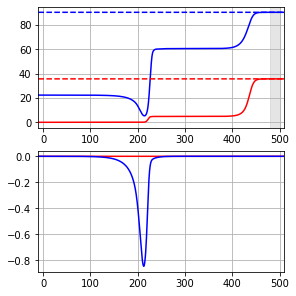

-------  50 0.47500000000000014 0.6000000000000003


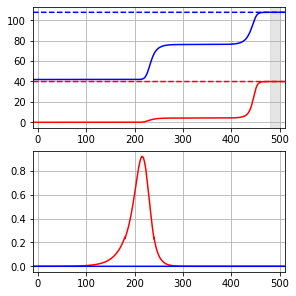

In [87]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    aln.params.duration = dur + dur_pre + dur_post

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

In [11]:
file_ = '1_p.pickle'

bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  48.6693338482971
RUN  2 , total integrated cost =  44.37245884829697
RUN  3 , total integrated cost =  44.2503885359628
RUN  4 , total integrated cost =  44.25011412016801
RUN  5 , total integrated cost =  44.25010891339888
RUN  6 , total integrated cost =  44.250098245147
RUN  7 , total integrated cost =  44.25009282364989
RUN  8 , total integrated cost =  44.25008281625311
RUN  9 , total integrated cost =  44.25007777611333
RUN  10 , total integrated cost =  44.2500681891226
RUN  10 , total integrated cost =  44.2500681891226
Improved over  10  iterations in  1.2286016499856487  seconds by  71.43670380583106  percent.


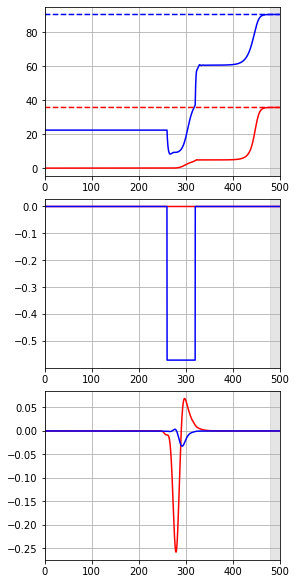

uncontrolled cost :  636.9058225135838
cost splitting :  0.00024084006729916725 [0.         4.42500561]
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  61.16933384829721
RUN  2 , total integrated cost =  55.309958848297555
RUN  3 , total integrated cost =  55.22450962954758
RUN  4 , total integrated cost =  55.218787583650006
RUN  5 , total integrated cost =  55.21862243072874
RUN  6 , total integrated cost =  55.21862102911382
RUN  7 , total integrated cost =  55.21862016482773
RUN  8 , total integrated cost =  55.21861907383675
RUN  9 , total integrated cost =  55.218618328665116
RUN  10 , total integrated cost =  55.21861740365094
RUN  10 , total integrated cost =  55.21861740365094
Improved over  10  iterations in  1.3849259029957466  seconds by  64.356535732510

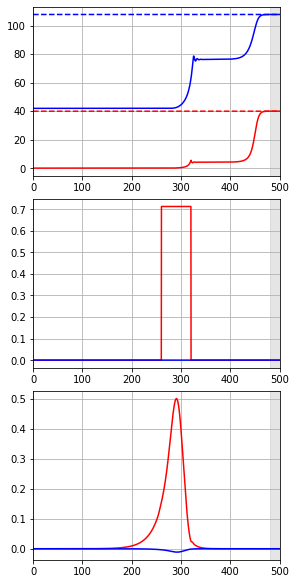

uncontrolled cost :  797.1477718037709
cost splitting :  7.105028961711407e-05 [5.52186139 0.        ]


In [45]:
cgv = None
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    cost.setParams(wp, 0., 10.)
    max_it = int(10)

    if i == 20:
        control0[0,1,2600:3200] = -2.
        c_var = [1]
    if i == 50:
        control0[0,0,2600:3200] = 2.
        c_var = [0]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
        ax[1].plot(plot_time_array, bestControl_[i][0,0,n_pre-1:-n_post+1], color = 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[1].plot(plot_time_array, bestControl_[i][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')


        ax[2].plot(plot_time_array, phi_[0,0,:], color = 'red')
        ax[2].plot(plot_time_array, phi_[0,1,:], color = 'blue')
        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])    

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  3.331182286326008
RUN  0 , total integrated cost =  3.331182286326008
Gradient descend method:  None
RUN  1 , total integrated cost =  3.3311594872849137
RUN  2 , total integrated cost =  3.3311594872804298
RUN  3 , total integrated cost =  3.331159487280425
RUN  4 , total integrated cost =  3.331159487280425
Control only changes marginally.
RUN  4 , total integrated cost =  3.331159487280425
Improved over  4  iterations in  1.8539746839996951  seconds by  0.000684413028878339  percent.
cost splitting :  8.773027737778373e-06 [1.62479151e-15 3.33115905e+00]
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  3.331159487280425
RUN  0 , total integrated cost =  3.331159487280425
Gradient descend method:  None
RUN  1 , total integrated cost =  3.331159487280425
Control only changes marginally.
RUN  1 , total integrated cost

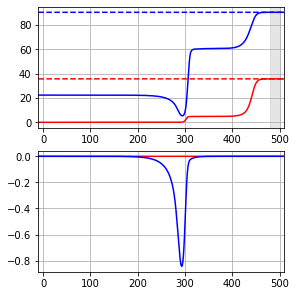

-------  50 0.47500000000000014 0.6000000000000003


In [14]:
c_var = [0,1]
conv = [None] * len(exc)
max_it = int(60)

tol = 1e-15

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i == 50:
        continue
    
    k = 0
    
    while not conv[i]:

        weight_ = random.random() * ( cost_uncontrolled[i] -
                                     costnode_[i][0][0][0] ) / sum( costnode_[i][2][0][:] )
        
        weight_ = 1.
            
        aln.params.duration = dur
        cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            conv[i] = True

        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])

        if conv[i]:
            time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]
        
            fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
            ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
            ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
            ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
            ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
            ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
            ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
            ax[0].set_xlim(-dur_pre,dur+dur_post)
            ax[1].set_xlim(-dur_pre,dur+dur_post)
            ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        
        k += 1

-------  20 0.4500000000000001 0.4750000000000002


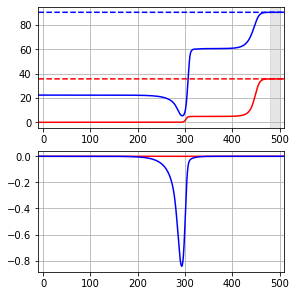

-------  50 0.47500000000000014 0.6000000000000003


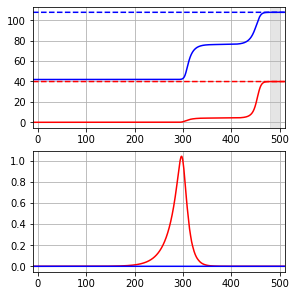

In [96]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    aln.params.duration = dur + dur_pre + dur_post

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()